# CHB-MIT eeg dataset seizure detection demo
This notebook is demo for seizure detection using CHB-MIT eeg dataset.  
In this notebook, deep learning model with 2d CNN is buit for seizure detection.  
Keras is used for deep learning platform.  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
# install library for reading edf files and visualization of NN model

#!pip install pyedflib visualkeras

In [3]:
#import numpy as np
import matplotlib.pyplot as plt
#import pyedflib
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



# Data manipulation
First of all, let's create training data.  
1. Patients are divided into training and test group.
2. EEG data of 8 sec with labels are extracted form training group.
3. Preprocessing: EEG data, originally 256 Hz sampling rate, are resampled to 128 Hz.
4. EEG data is divided into test data and validation data. The validation data is used for early stopping.

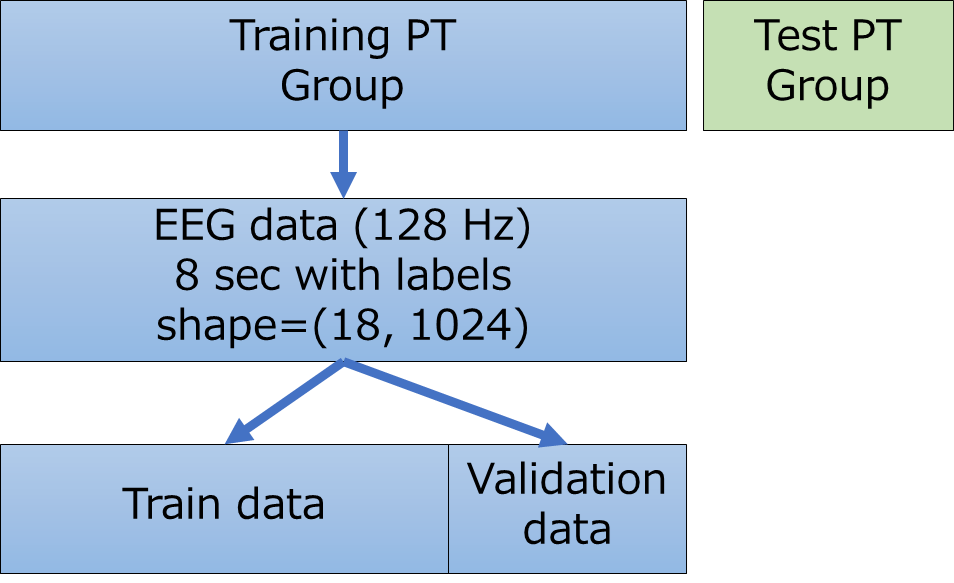

#### Channels are of bipolar montage. EEG waves are lined up as listed below.

In [4]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

#### Patients folders are placed in /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/.
#### Patients' ID are extracted by folder names.

In [5]:
path2pt = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


#### Patients are randomly divided into training and test groups.

In [6]:






random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [7]:
# file names for training and test data

files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [8]:
len(files_train), len(files_test)

(549, 137)

In [9]:
temp_edf = mne.io.read_raw_edf("/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_12.edf")
temp_edf

Extracting EDF parameters from /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_32/3511158915.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf = mne.io.read_raw_edf("/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_12.edf")


<RawEDF | chb07_12.edf, 23 x 3686400 (14400.0 s), ~27 kB, data not loaded>

## Signal Extraction for training data
Each 8 second signals of 18 channels are extracted, sliding forward by 4 seconds.  
Each set of signals are labeled with the ratio of seizure in the time window. i.e. a set of signals are labeled 1.0 if it is in the middle of seizure.  

To save time, already extracted signals and labels are located in /kaggle/input/mit-chb-processed, and they will be loaded.  
You may try extracting by deleteing the processed data.

In [10]:
mne.set_log_level(verbose='ERROR')

In [11]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4

if os.path.exists('/kaggle/input/mit-chb-processed/signal_samples.npy')&os.path.exists('/kaggle/input/mit-chb-processed/is_sz.npy'):
    array_signals=np.load('/kaggle/input/mit-chb-processed/signal_samples.npy')
    array_is_sz=np.load('/kaggle/input/mit-chb-processed/is_sz.npy')
else:
    p = 0.01  
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs
            
            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times
            
            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
        
        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()
    
    np.save('signal_samples', array_signals)
    np.save('is_sz', array_is_sz)

In [12]:
print(temp_edf.times[2]- temp_edf.times[1])


0.00390625


In [13]:
array_signals.shape

(9505, 18, 2048)

In [14]:
import numpy as np
import pandas as pd

# Path to your NumPy file
numpy_file_path = '/kaggle/input/mit-chb-processed/signal_samples.npy'

# Load the NumPy file
array_signals = np.load(numpy_file_path)

# Assuming the shape is (num_samples, num_signals, signal_length)
num_samples, num_signals, signal_length = array_signals.shape

# Generate signal labels (if not provided, here using default labeling)
signal_labels = [f'Channel {i+1}' for i in range(num_signals)]

# Print some basic information about the file
print(f"Number of samples: {num_samples}")
print(f"Number of signals: {num_signals}")
print(f"Signal length: {signal_length}")
print(f"Signal labels: {signal_labels}")

# Convert to DataFrame
df = pd.DataFrame()

# Assume we are only interested in the first sample for simplicity
for i in range(num_signals):
    df[signal_labels[i]] = array_signals[0, i, :]

# Print the signal data
print(df)

# If you want to save it as a CSV or perform other operations, you can proceed from here
# df.to_csv('signal_data.csv', index=False)


Number of samples: 9505
Number of signals: 18
Signal length: 2048
Signal labels: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'Channel 14', 'Channel 15', 'Channel 16', 'Channel 17', 'Channel 18']
      Channel 1  Channel 2  Channel 3  Channel 4  Channel 5  Channel 6  \
0     37.704517  41.221001  11.135531 -12.698413  53.333332  33.797314   
1     38.876678  35.750916  12.307693  -9.572650  53.724052  32.234432   
2     35.750916  32.234432   8.791209  -6.056166  52.551891  30.671551   
3     39.267399  31.452991   5.274725  -6.056166  52.942612  31.452991   
4     39.267399  29.108669   2.539683  -2.148962  50.207569  33.015873   
...         ...        ...        ...        ...        ...        ...   
2043 -11.526252   3.711844  27.936508   0.586081  -8.400489   4.884005   
2044 -10.744811   9.572650  27.155067  -2.148962  -4.493285   4.884005   
2045 -13.

## preprocess
#### Signals frequencies are originally 256 Hz, but resampled to 128 Hz for simplification of the data.

In [15]:
array_signals = array_signals[:, :, ::2]

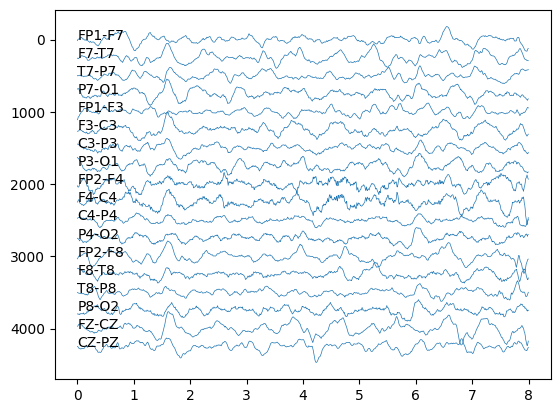

In [16]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 128

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [17]:
# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 9505
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.272


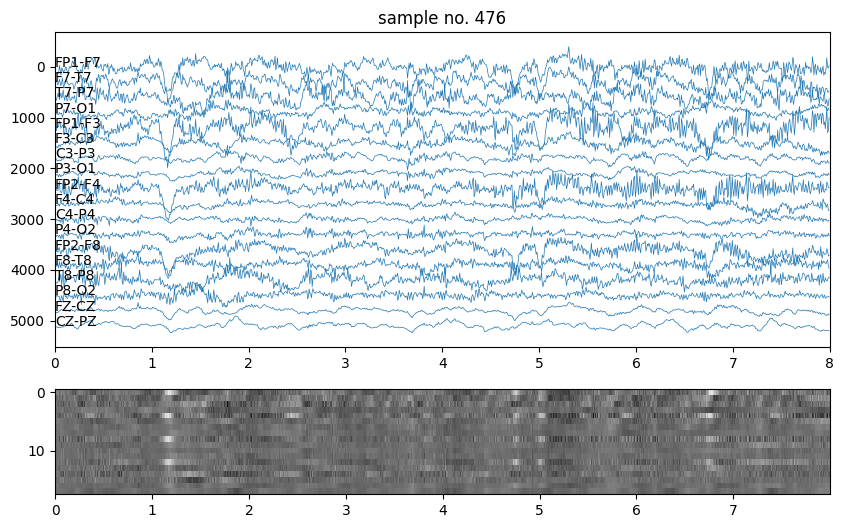

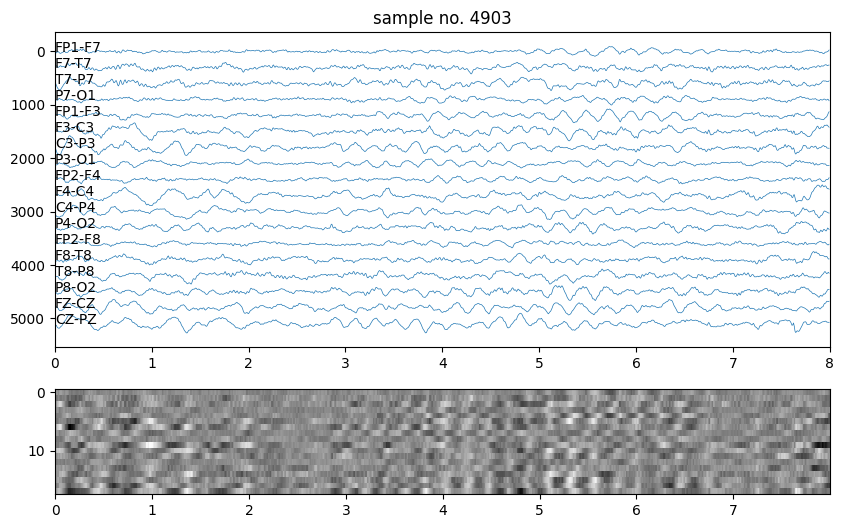

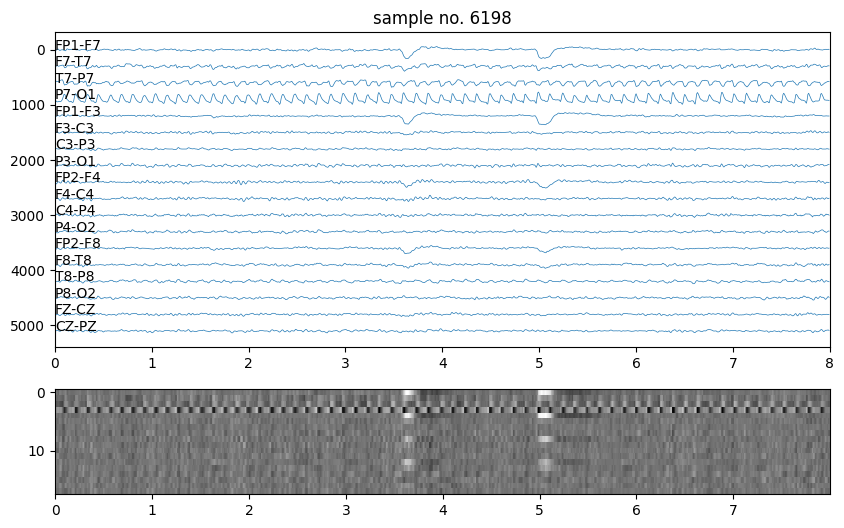

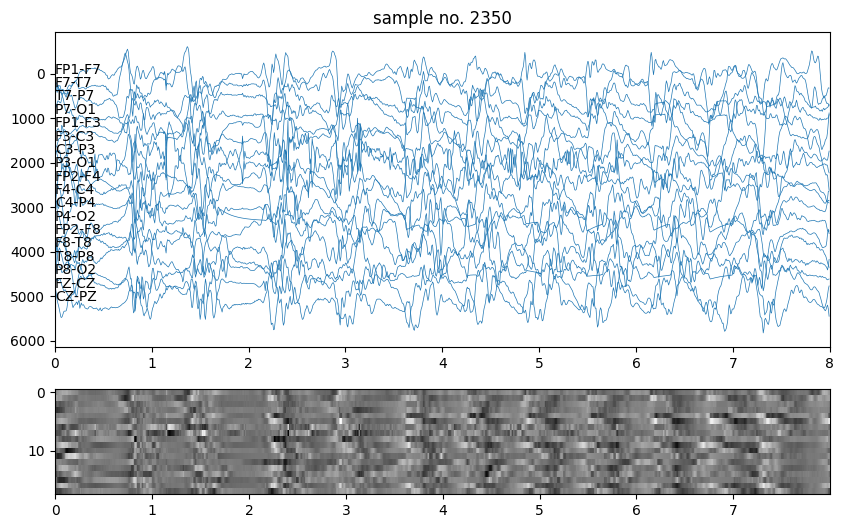

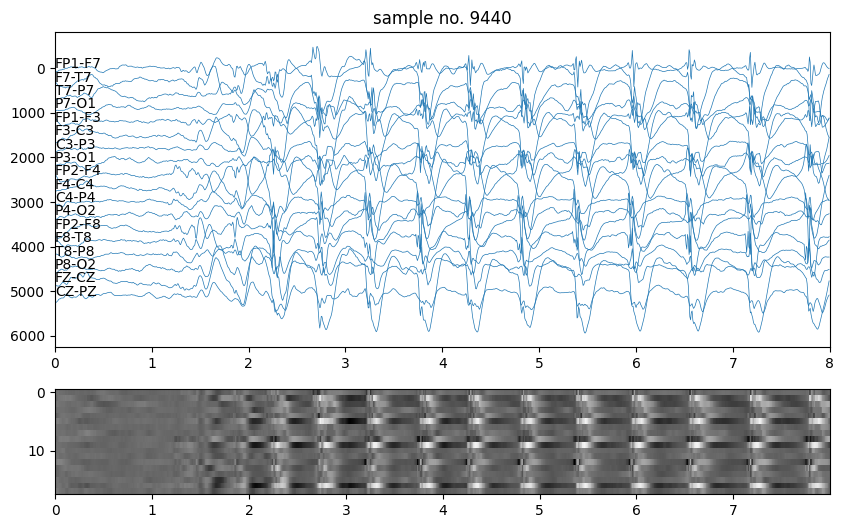

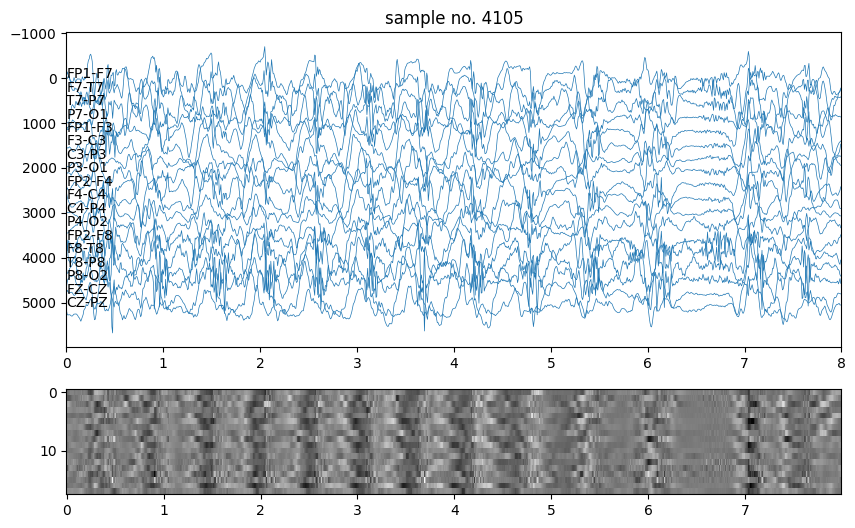

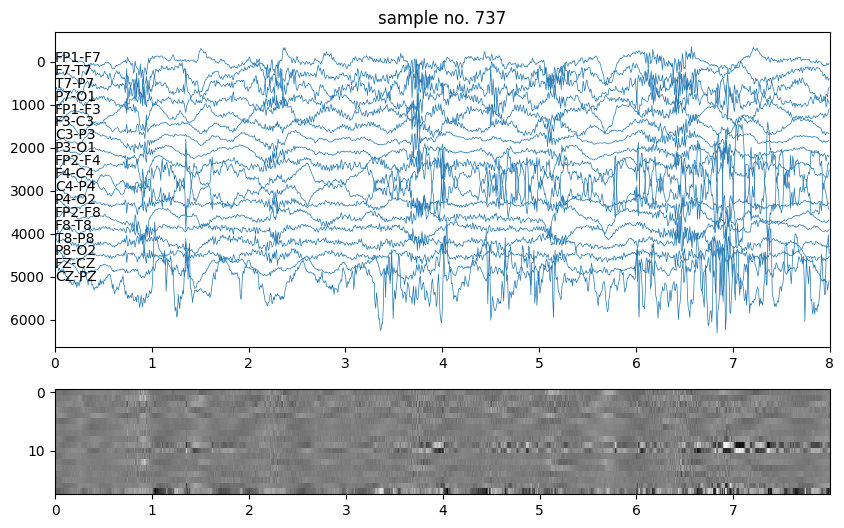

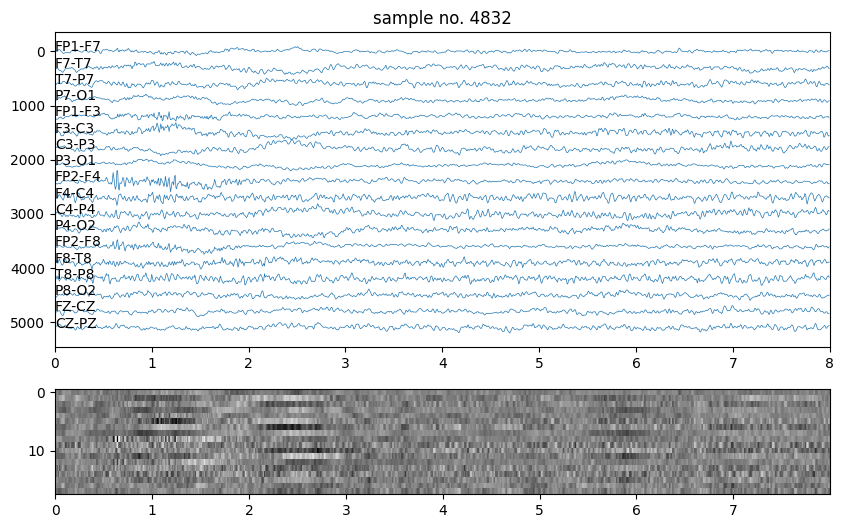

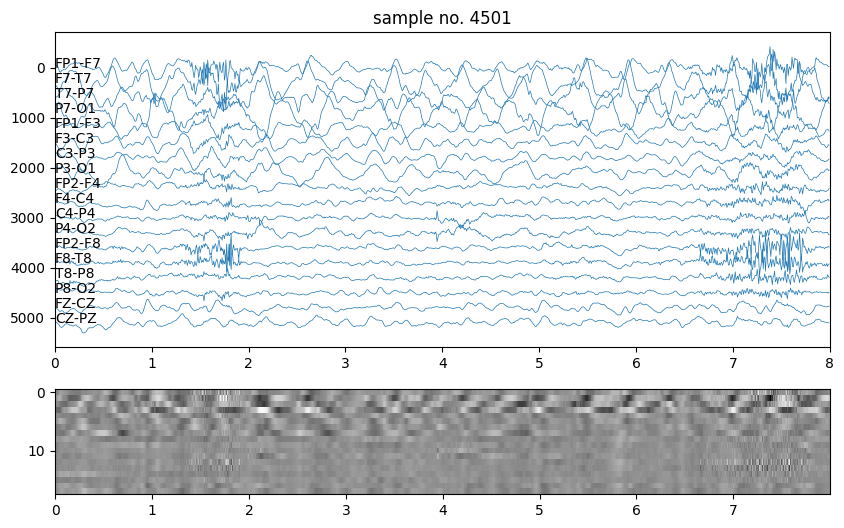

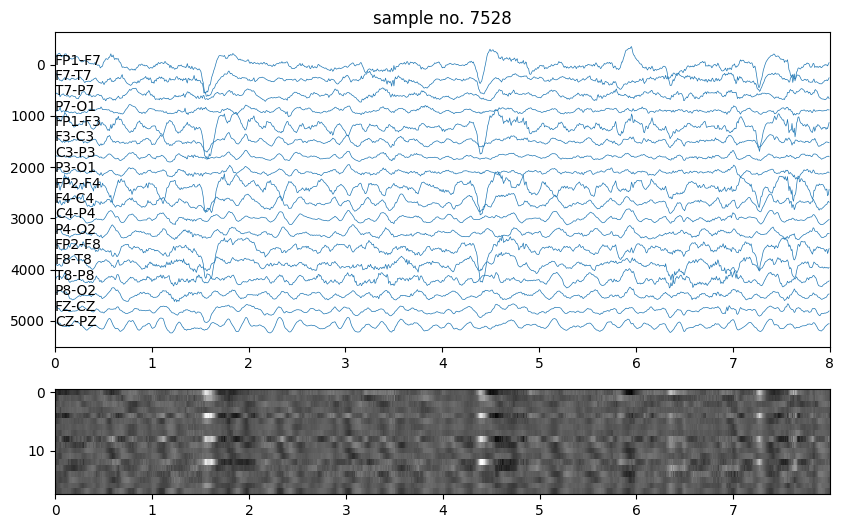

In [18]:
# Let's see samples with seizures.

for n in random.sample(list(array_n), 10):

    vertical_width = 300
    temp_signals = array_signals[n, :, :]
    fs = 128

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1])/fs, temp_signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i*vertical_width))
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title('sample no. {}'.format(n))
    
    ax[1].pcolormesh(np.arange(temp_signals.shape[-1])/fs, np.arange(len(ch_labels)), temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()
    
    plt.show()

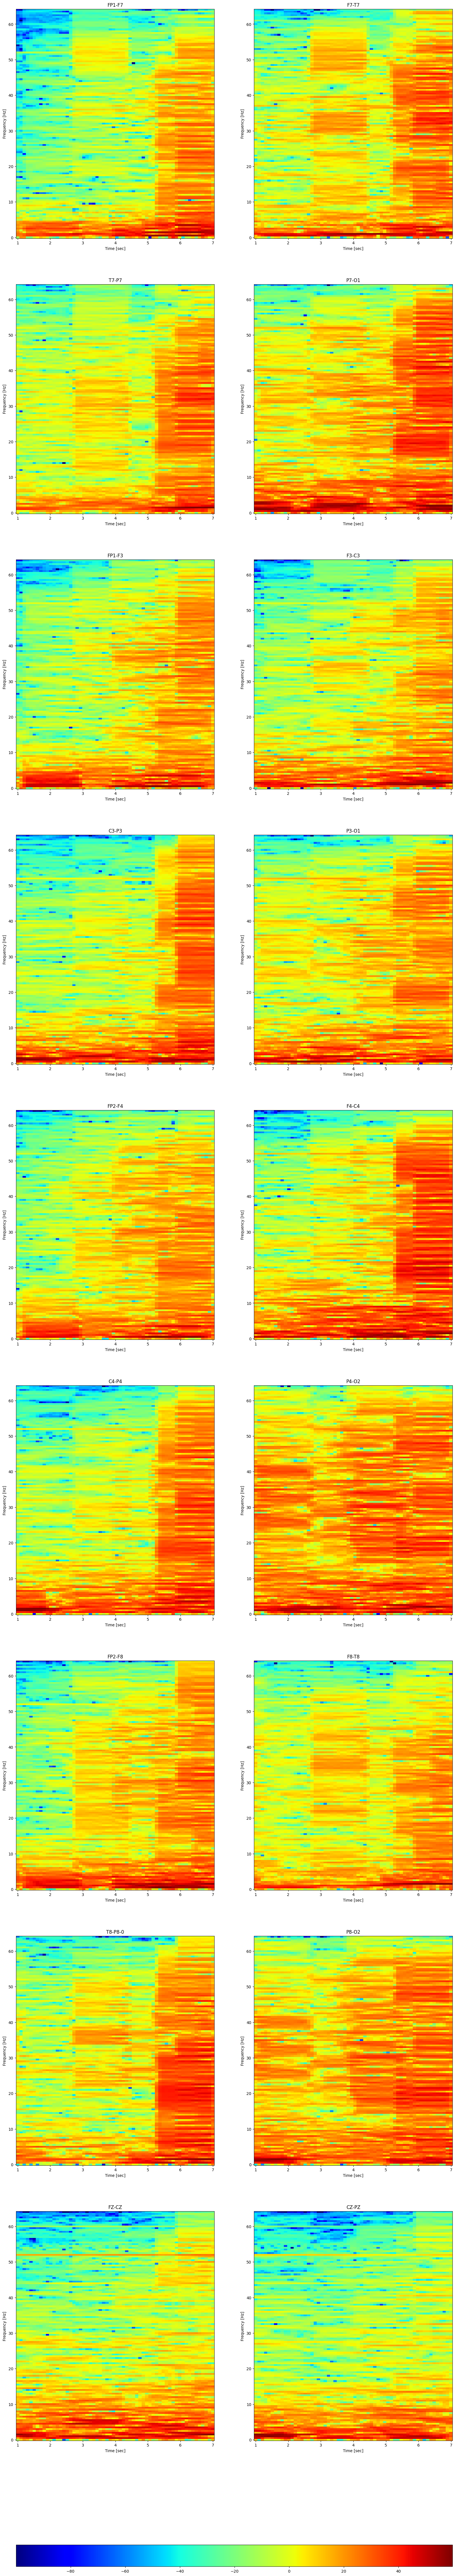

In [19]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, lfilter
def plot_spectrogram(data, title, ax):
    f, t, Sxx = spectrogram(data, fs=128, nperseg=256, noverlap=int(256 * 0.95), scaling='density', return_onesided=True)
    Sxx_db = 10 * np.log10(np.abs(Sxx)**2 + 1e-10)  # Add a small value to avoid log(0)
    mn = np.min(Sxx_db)
    mx = np.max(Sxx_db)
    normalize_color= matplotlib.colors.Normalize(vmin=mn, vmax=mx)
    cax = ax.pcolormesh(t, f, Sxx_db, cmap='jet', norm=normalize_color)
    ax.set_title(title)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    return cax,f,t,Sxx


# Plot spectrograms for each feature in a 4x2 grid
fig, axs = plt.subplots(9, 2, figsize=(20, 120))

for i in range(18):
    row, col = divmod(i, 2)
    cax,f,t,Sxx = plot_spectrogram(array_signals[100, i,:], f'{temp_edf.ch_names[i]}', axs[row, col])


fig.colorbar(cax, ax=axs, orientation='horizontal', fraction=0.025, pad=0.04)
plt.show()

In [20]:
print(array_signals.shape)  
for i in range(18):
    print(array_signals[100, i, :].shape)  


(9505, 18, 1024)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)


In [21]:
Sxx.shape

(129, 60)

In [22]:
# f, t, Sxx = spectrogram(array_signals[200], fs=fs, nperseg=100, noverlap=int(100 * 0.95), scaling='density', return_onesided=True)


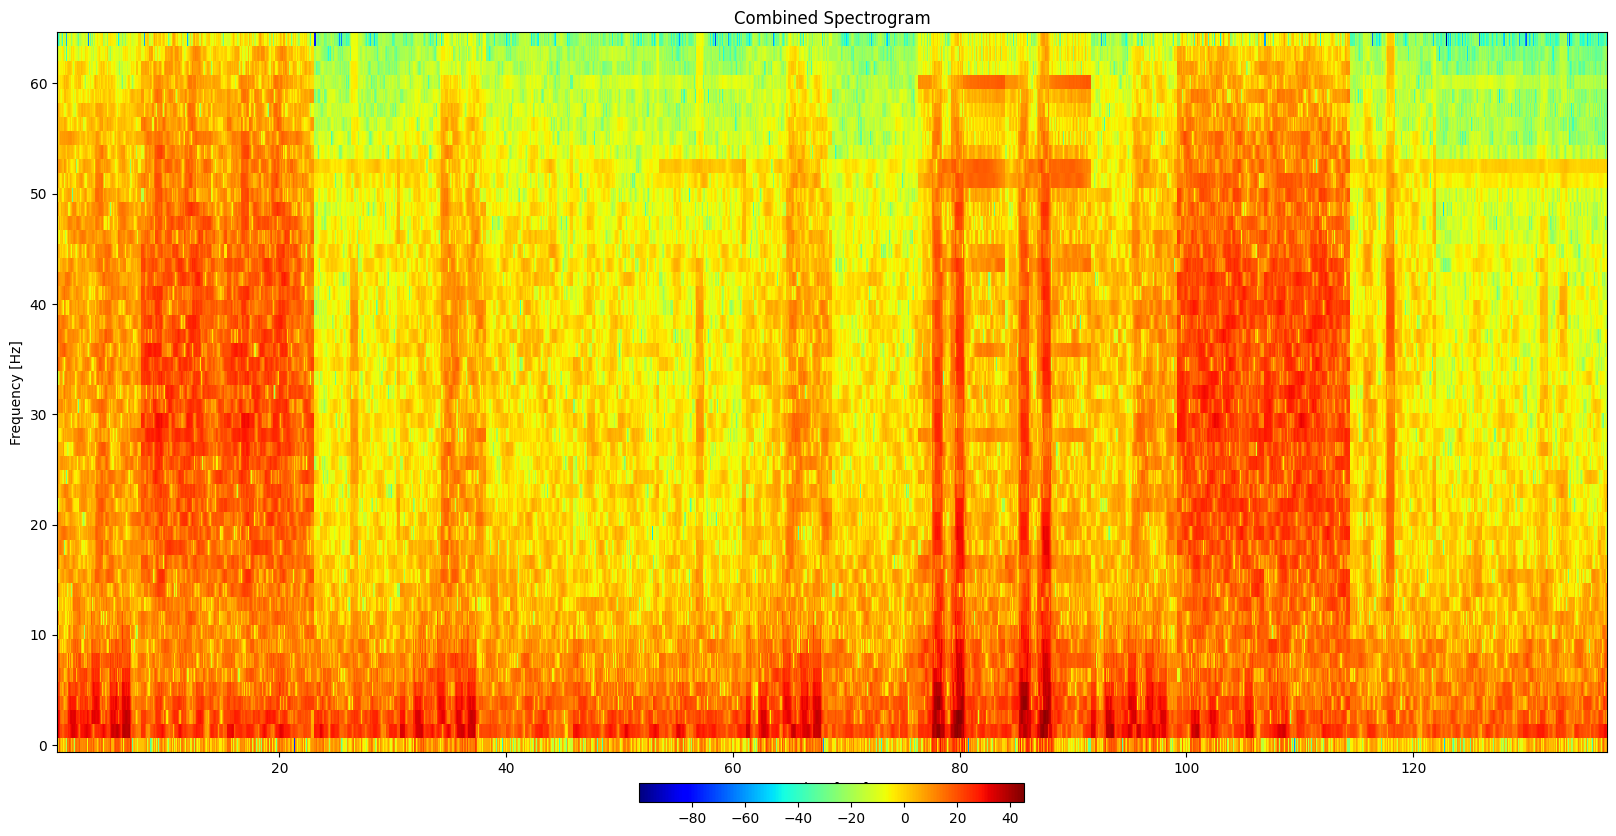

In [23]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_combined_spectrogram(data, fs, ax):
    combined_Sxx = None
    combined_t = None

    for i in range(data.shape[0]):  # Loop over each channel
        f, t, Sxx = spectrogram(data[i, :], fs=fs, nperseg=100, noverlap=int(100 * 0.95), scaling='density', return_onesided=True)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Convert to dB

        if combined_Sxx is None:
            combined_Sxx = Sxx_db
            combined_f = f
            combined_t = t
        else:
            combined_Sxx = np.hstack((combined_Sxx, Sxx_db))  # Concatenate horizontally
            combined_t = np.hstack((combined_t, t + combined_t[-1] + (t[1] - t[0])))  # Adjust time scale

    mn = np.min(combined_Sxx)
    mx = np.max(combined_Sxx)
    normalize_color = matplotlib.colors.Normalize(vmin=mn, vmax=mx)
    
    cax = ax.pcolormesh(combined_t, combined_f, combined_Sxx, cmap='jet', norm=normalize_color)
    ax.set_title('Combined Spectrogram')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    return cax

# Plot combined spectrogram
fig, ax = plt.subplots(figsize=(20, 10))
cax = plot_combined_spectrogram(array_signals[200], fs=128, ax=ax)

fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=0.025, pad=0.04)
plt.show()


In [24]:
Sxx.shape

(129, 60)

In [25]:
import matplotlib
from scipy.signal import spectrogram

# Define the compute_concatenated_spectrogram function
def compute_concatenated_spectrogram(data, fs):

    concatenated_Sxx_db = None
    for i in range(data.shape[0]):  # Loop over each channel
        
        f, t, Sxx = spectrogram(data[i, :], fs=fs, nperseg=250, noverlap=int(256 * 0.95), scaling='density', return_onesided=True)

        Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Convert to dB

        
        if concatenated_Sxx_db is None:
            concatenated_Sxx_db = Sxx_db
        else:
            concatenated_Sxx_db = np.concatenate((concatenated_Sxx_db, Sxx_db), axis=0)

            
    return concatenated_Sxx_db



In [26]:
# import numpy as np

# # Initialize an empty list to collect the spectrograms
# spec = []

# # Loop to fill the list
# for i in range(len(array_signals)):
#     spect = compute_concatenated_spectrogram(array_signals[i], 128)
#     spec.append(spect)

# # Convert the list to a NumPy array
# d = np.array(spec)

In [27]:
# d.shape

In [28]:
# from sklearn import model_selection

In [29]:
# # CNN will be used. Channel dimension is added.
# d = d[:, :, :, np.newaxis]

# array_signals.shape

In [30]:
# d.shape

In [31]:
# # splitting training data into training & validation data.

# X_train, X_val, y_train, y_val = model_selection.train_test_split(
#     d, array_is_sz, test_size=0.3,
#     stratify=(array_is_sz>0))

# del array_signals, array_is_sz,d

# Building and training deep learning models with Keras
We will make deep learning model with 2D-CNN and FC.  
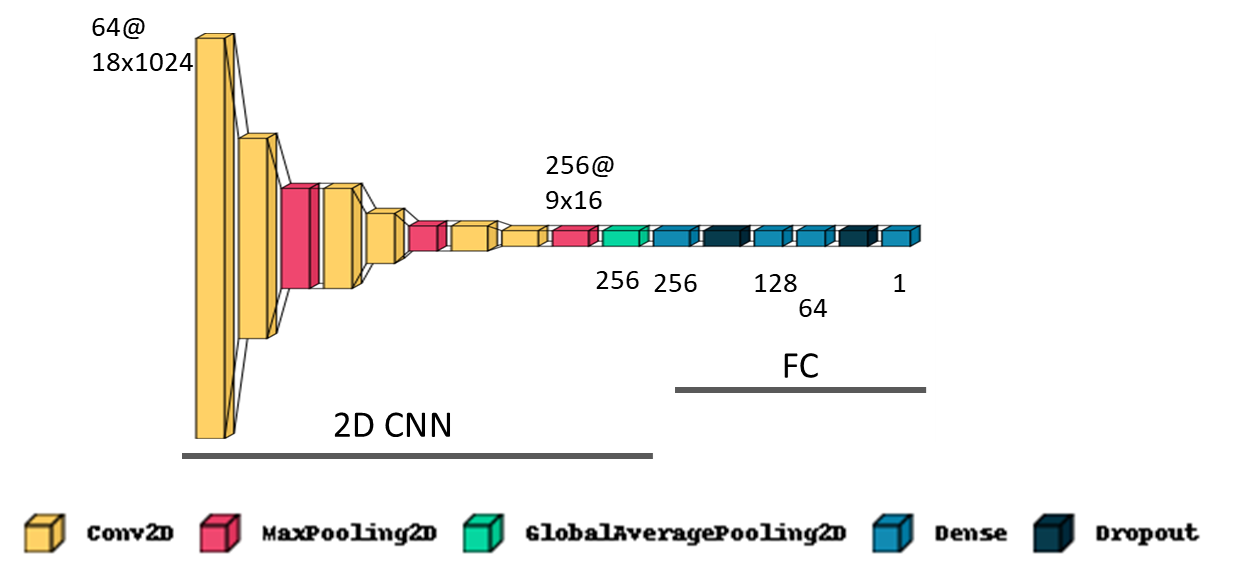

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

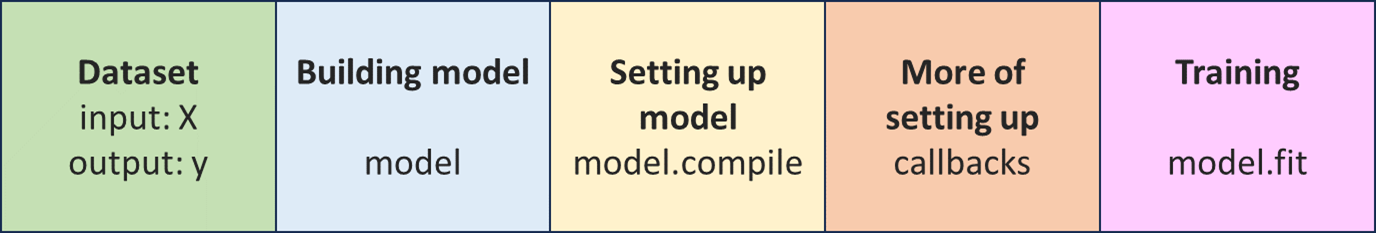

In [33]:
# ## deep learning model

# model = keras.models.Sequential()

# model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
# model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
# model.add(layers.MaxPooling2D((1, 2)))

# model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
# model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
# model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D((1, 2)))

# model.add(layers.GlobalAveragePooling2D())
# #model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
# model.summary()  

In [35]:
# from keras.utils import plot_model
# #plot_model(model, show_shapes=True, to_file='model.png')
# plot_model(model, show_shapes=True, dpi=70)

In [36]:
#import visualkeras
#visualkeras.layered_view(model, scale_xy=0.5, legend=True)

### Setup for training
### At least, **OPTIMIZER** and **LOSS** has to be set.

In [37]:
# LEARNING_RATE = 1e-4
# OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
# # callbacks
# VERBOSE=1
# #lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
# es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

# callbacks = [es]

In [39]:
# X_train.shape, y_train.shape, X_val.shape, y_val.shape

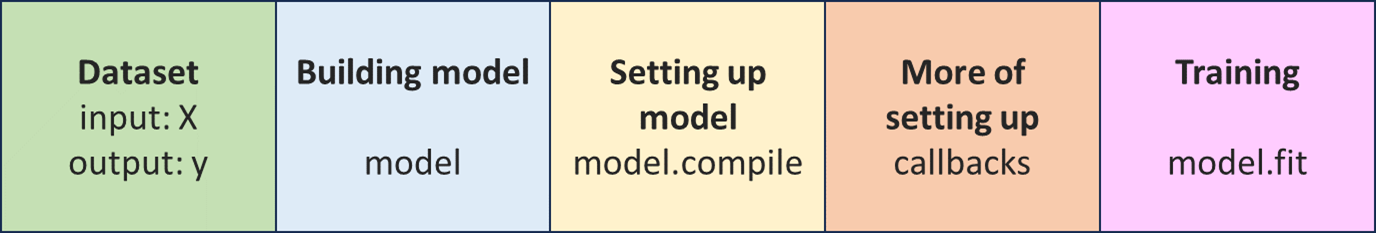

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import matplotlib

# Function to compute concatenated spectrogram
def compute_concatenated_spectrogram(data, fs):
    concatenated_Sxx_db = None
    for i in range(data.shape[0]):  # Loop over each channel
        f, t, Sxx = spectrogram(data[i, :], fs=fs, nperseg=250, noverlap=int(250 * 0.95), scaling='density', return_onesided=True)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Convert to dB

        if concatenated_Sxx_db is None:
            concatenated_Sxx_db = Sxx_db
        else:
            concatenated_Sxx_db = np.concatenate((concatenated_Sxx_db, Sxx_db), axis=0)

    return concatenated_Sxx_db

# Example usage with array_signals
# Initialize an empty list to collect the spectrograms
spec = []

# Loop to fill the list
for i in range(len(array_signals)):
    spect = compute_concatenated_spectrogram(array_signals[i], 128)
    spec.append(spect)

# Convert the list to a NumPy array
d = np.array(spec)

# Add channel dimension for CNN input
d = d[:, :, :, np.newaxis]

# Split training data into training & validation data.
X_train, X_val, y_train, y_val = train_test_split(
    d, array_is_sz, test_size=0.3, stratify=(array_is_sz > 0))

# Verify the shapes
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")

# Delete large arrays to free memory
del array_signals, array_is_sz, d, spec

# Define the ResNet-like model
def resnet_block(input_tensor, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(input_tensor)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, 1, strides=stride, padding='same', activation=None)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)
        
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

input_shape = X_train.shape[1:]
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

for filters in [64, 128, 256, 512]:
    strides = 2 if filters != 64 else 1
    x = resnet_block(x, filters, stride=strides)
    x = resnet_block(x, filters, stride=1)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
VERBOSE = 1
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

# Check the model summary
model.summary()

# Train the model
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,  # Try with a smaller batch size
    callbacks=callbacks
)

X_train.shape: (6653, 2268, 60, 1), y_train.shape: (6653,)
X_val.shape: (2852, 2268, 60, 1), y_val.shape: (2852,)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2268, 60, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 1134, 30, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 567, 15, 64)  0           ['conv2d[0][0]

In [ ]:
# hist = model.fit(
#     x=X_train, y=y_train,
#     validation_data=(X_val, y_val),
#     epochs=200,
#     batch_size=64,
#     callbacks=callbacks
# )

In [42]:
model.save('CHB_MIT_sz_detec_demo.h5')

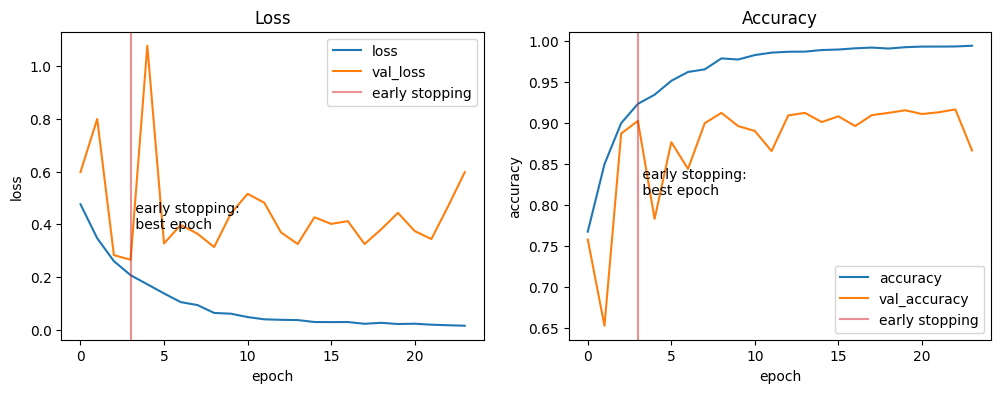

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [44]:
# You may just load model without training. To do so, just run the code below by omitting '#'.

#model = keras.models.load_model('/kaggle/input/mit-chb-processed/CHB_MIT_sz_detec_demo.h5')

# Evaluating the model with test data

## Evaluation of the model by scores and ROC

In [45]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [46]:
y_pred = (model.predict(X_val)>0.5).astype(int)

90/90 [==============================] - 4s 40ms/step


In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

       False       0.96      0.91      0.93      2078
        True       0.78      0.89      0.83       774

    accuracy                           0.90      2852
   macro avg       0.87      0.90      0.88      2852
weighted avg       0.91      0.90      0.90      2852



In [49]:
from tqdm import tqdm

list_pred = []
list_true = []

for f in tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]
    
    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)


100%|██████████| 137/137 [05:02<00:00,  2.21s/it]


In [50]:
from sklearn import metrics

In [51]:
# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    186865
        True       0.00      0.00      0.00       629

    accuracy                           0.99    187494
   macro avg       0.50      0.50      0.50    187494
weighted avg       0.99      0.99      0.99    187494



In [54]:
# # threshold = 0.9
# report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
# print(report)

In [55]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

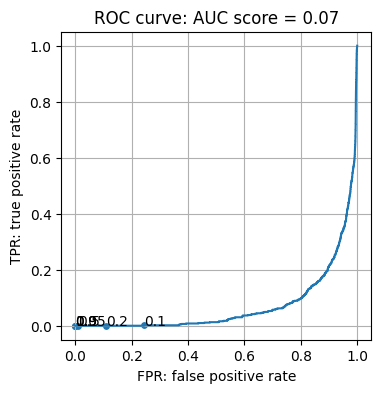

In [56]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

### Seizure detection using the deep learning model
The model predicts seizure existance.  
This detects seizure but does not indicate the seizure onset.  
To find the seizure onsets, peak detection of p is used (distance>6, threshold>=.95).

In [57]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 9 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf
Index = 11 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_26.edf
Index = 12 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf
Index = 20 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf
Index = 24 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf
Index = 30 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf
Index = 37 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf
Index = 50 has seizures: /kaggle/in

In [58]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n
    
    return temp

In [59]:
# get signals and labels from test data.
n=100
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = model.predict(array_signals)

/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_89.edf: Reading. 
57/57 [==============================] - 1s 11ms/step


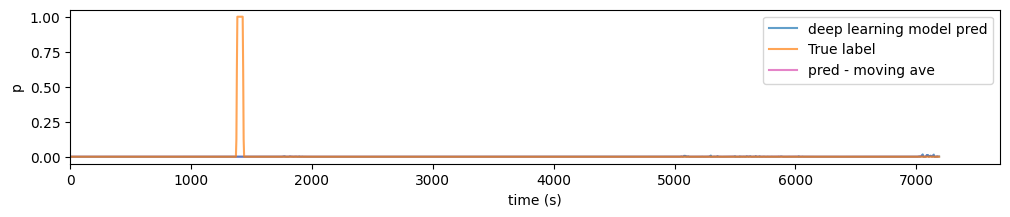

In [60]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()



In [62]:
if pred_peaks.size==0:
    print('No seizure detected.')
else:
    f = files_test[n]
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

    fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
    for n_peak in range(pred_peaks.size):
        ind_peak = pred_peaks[n_peak]*time_step*fs
        backward_steps = 30*fs
        forward_steps = 15*fs
        vertical_width=500

        fig, ax = plt.subplots(figsize=(10, 6))
        for i in range(temp_signals.shape[0]):
            ax.plot(np.arange(ind_peak-backward_steps, ind_peak+forward_steps)/fs,
                    temp_signals[i, ind_peak-backward_steps:ind_peak+forward_steps]+i*vertical_width, linewidth=0.5, color='tab:blue')
            ax.annotate(ch_labels[i], xy=((ind_peak-backward_steps)/fs, i*vertical_width))
        ax.axvline(x=ind_peak/fs, color='tab:red', alpha=0.5, label='Seizure detection point')
        ax.invert_yaxis()
        ax.legend(loc='upper right')
        plt.show()
    #ax.set_xlim(0, 8)

    temp_edf.close()

No seizure detected.
